
# Estimation de posture dans une image

Pour ce TP ainsi que le suivant, nous allons traiter le problème de la détection du "squelette" d'un humain dans une image, tel qu'illustré dans la figure ci-dessous.

![Texte alternatif…](https://drive.google.com/uc?id=1HpyLwzwkFdyQ6APoGZQJL7f837JCHNkh)

Nous allons pour ce faire utiliser le [Leeds Sport Pose Dataset](https://sam.johnson.io/research/lspet.html) qui introduit 10000 images présentant des sportifs dans diverses situations, augmentées d'une annotation manuelle du squelette.

À chaque image est associée une matrice de taille 3x14, correspondant aux coordonnées dans l'image des 14 joints du squelette de la personne décrite dans l'image. La 3e dimension désigne la visibilité du joint (1 s'il est visible, 0 s'il est occulté)

Ces joints sont, dans l'ordre :
*   Cheville droite
*   Genou droit
*   Hanche droite
*   Hanche gauche
*   Genou gauche
*   Cheville gauche
*   Poignet droit
*   Coude droit
*   Épaule droite
*   Épaule gauche
*   Coude gauche
*   Poignet gauche
*   Cou
*   Sommet du crâne

Pour un rappel des notions vues en cours sur ce sujet, vous pouvez regarder la vidéo ci-dessous :


In [29]:
from IPython.display import IFrame
IFrame("https://video.polymny.studio/?v=84ace9c1-f460-4375-9b33-917c3ff82c83/", width=640, height=360)

# Méthodologie

Pour résoudre ce problème, nous allons suivre une méthodologie similaire à celle présentée dans le 2e cours, et rappelée sur la figure suivante :

![Méthodologie de développement d'un algorithme d'apprentissage profond](https://drive.google.com/uc?id=195pkcjca4r_g86KDt2LCe0QdQsMC6iba)

Ainsi nous allons commencer par une modélisation simple du problème, construire un modèle et l'améliorer pas à pas et évaluer sa performance.
Dans un second temps, nous modifierons la modélisation du problème, et donc l'architecture utilisée, afin d'améliorer les résultats.

Pour chacune de ces deux étapes, je vous suggère de suivre la démarche suivante :

- Simplifier le problème en traitant 10 imagettes (par exemple de dimension $64 \times 64$) et construire un réseau qui surapprend parfaitement (qui diminue la perte jusqu'à quasiment 0)
- Ajouter des images (~1000) et recalibrer le réseau pour à nouveau, obtenir un sur-apprentissage
- Commencer à corriger le sur-apprentissage en ajoutant de la régularisation
- Et enfin, utiliser l'ensemble de la base de données pour diminuer le sur-apprentissage au maximum

# Régression de la position des joints

Dans un premier temps, et comme vu en cours, nous allons nous inspirer de l'algorithme DeepPose (**[Toshev et al.] DeepPose : Human Pose Estimation via Deep Neural Networks**) et formuler le problème comme une régression de la position (x,y) des joints dans l'espace de l'image.

Commencez par télécharger la base de données sur Github




In [30]:
!git clone https://github.com/axelcarlier/lsp.git

fatal: destination path 'lsp' already exists and is not an empty directory.


Le bloc suivant contient une fonction qui permet de charger les images de la base de données dans les variables x et y. Par défaut les images sont redimensionnées en taille 128$\times$128 et la base de données contient 1000 images. Pour commencer et vous permettre de travailler plus efficacement, **je vous suggère très fortement de diminuer la dimension des images** (par exemple 64$\times$64) **et de ne travailler que sur un ensemble réduit d'images** (par exemple, 10).


N'oubliez pas également de diviser les données en images de test et/ou de validation pour obtenir des informations sur le sur-apprentissage éventuel.


In [31]:
import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat

# Cette fonction permettra plus tard de charger plus ou moins d'images (en modifiant le paramètre num_images)
# et de modifier la dimension d'entrée
def load_data(image_size=64, num_images=1000):

  path = "./lsp/images/"
  dirs = sorted(os.listdir(path))

  x = np.zeros((min(num_images,len(dirs)),image_size,image_size,3))
  y = np.zeros((min(num_images,len(dirs)), 3, 14))

  #Chargement des joints
  mat_contents = loadmat('./lsp/joints.mat')
  joints = mat_contents['joints']

  # Chargement des images, qui sont rangées dans lsp/images
  for i in range(min(num_images,len(dirs))):
    item = dirs[i]
    if os.path.isfile(path+item):
        img = Image.open(path+item)
        # Redimensionnement et sauvegarde des joints
        y[i, 0] = joints[:,0,i]*image_size/img.size[0]
        y[i, 1] = joints[:,1,i]*image_size/img.size[1]
        y[i, 2] = joints[:,2,i]
        # Redimensionnement et sauvegarde des images
        img = img.resize((image_size,image_size))
        x[i] = np.asarray(img)


  return x, y

# Chargement de seulement 10 images, de taille 64x64
x, y = load_data(image_size=64, num_images=1000)
x.shape, y.shape

((1000, 64, 64, 3), (1000, 3, 14))

In [32]:
labels= {0: 'Cheville droite',
         1: 'Genou droit',
         2: 'Hanche droite',
         3: 'Hanche gauche',
         4: 'Genou gauche',
         5: 'Cheville gauche',
         6: 'Poignet droit',
         7: 'Coude droit',
         8: 'Épaule droite',
         9: 'Épaule gauche',
         10: 'Coude gauche',
         11: 'Poignet gauche',
         12: 'Cou',
         13: 'Sommet du crâne'}

La fonction suivante vous permet de visualiser les données. Vous vous rendrez compte que certaines données sont manquantes ! En effet quand des joints sont occultés dans les images, des valeurs de position aberrantes (négatives) sont indiquées. Dans ce cas, nous n'afficherons pas les articulations.

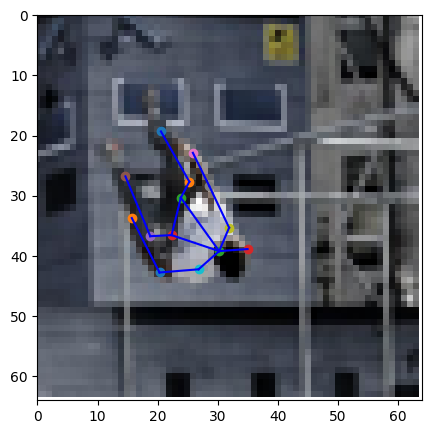

In [33]:
import matplotlib.pyplot as plt

# Fonction d'affichage d'une image et de son label associé
def print_data(x,y,i):

  if y.shape[1] < 3:
    y_new = np.ones((y.shape[0], 3, y.shape[2]))
    y_new[:,0:2,:] = y
    y = y_new

  plt.figure(figsize=(5, 5))
  plt.imshow(x[i]/255)
  for j in range(0,14):
    if y[i, 2, j] == 1:
        plt.scatter(y[i,0,j],y[i,1,j],label=labels.get(j))

  # Jambe droite
  if (y[i, 2, 0] + y[i, 2, 1] == 2):
      plt.plot(y[i,0,0:2],y[i,1,0:2],'b')
  # Cuisse droite
  if (y[i, 2, 1] + y[i, 2, 2] == 2):
      plt.plot(y[i,0,1:3],y[i,1,1:3],'b')
  # Bassin
  if (y[i, 2, 2] + y[i, 2, 3] == 2):
      plt.plot(y[i,0,2:4],y[i,1,2:4],'b')
  # Cuisse gauche
  if (y[i, 2, 3] + y[i, 2, 4] == 2):
      plt.plot(y[i,0,3:5],y[i,1,3:5],'b')
  # Jambe gauche
  if (y[i, 2, 4] + y[i, 2, 5] == 2):
      plt.plot(y[i,0,4:6],y[i,1,4:6],'b')
  # Avant-bras droit
  if (y[i, 2, 6] + y[i, 2, 7] == 2):
      plt.plot(y[i,0,6:8],y[i,1,6:8],'b')
  # Bras droit
  if (y[i, 2, 7] + y[i, 2, 8] == 2):
      plt.plot(y[i,0,7:9],y[i,1,7:9],'b')
  # Bras gauche
  if (y[i, 2, 9] + y[i, 2, 10] == 2):
      plt.plot(y[i,0,9:11],y[i,1,9:11],'b')
  # Avant-bras gauche
  if (y[i, 2, 10] + y[i, 2, 11] == 2):
      plt.plot(y[i,0,10:12],y[i,1,10:12],'b')
  # Buste droit
  x1=[y[i,0,2],y[i,0,12]]
  y1=[y[i,1,2],y[i,1,12]]
  if (y[i, 2, 2] + y[i, 2, 12] == 2):
      plt.plot(x1, y1,'b')
  # Buste gauche
  x1=[y[i,0,3],y[i,0,12]]
  y1=[y[i,1,3],y[i,1,12]]
  if (y[i, 2, 3] + y[i, 2, 12] == 2):
      plt.plot(x1, y1,'b')
  # Omoplate droite
  x1=[y[i,0,8],y[i,0,12]]
  y1=[y[i,1,8],y[i,1,12]]
  if (y[i, 2, 8] + y[i, 2, 12] == 2):
      plt.plot(x1, y1,'b')
  # Omoplate gauche
  x1=[y[i,0,9],y[i,0,12]]
  y1=[y[i,1,9],y[i,1,12]]
  if (y[i, 2, 9] + y[i, 2, 12] == 2):
      plt.plot(x1, y1,'b')
  # Tete
  if (y[i, 2, 12] + y[i, 2, 13] == 2):
      plt.plot(y[i,0,12:14],y[i,1,12:14],'b')

  plt.axis([0, x.shape[1], x.shape[2], 0])
  plt.show()
  #plt.legend()

# Affichage aléatoire d'une image
print_data(x,y,np.random.randint(x.shape[0]-1))


Si nous formulons ce problème comme une régression, nous allons utiliser pour évaluer nos réseaux de neurones l'erreur quadratique moyenne (fonction *MSE*). Cette fonction sera parfaite comme fonction de perte, mais elle ne permet pas d'appréhender les résultats de manière satisfaisante.

Une métrique commune en estimation de posture est le **PCK0.5**, pour *Percentage of Correct Keypoints*. *0.5* correspond à un seuil en-deça duquel on considère qu'un joint est correctement estimé. Cette question du seuil est particulièrement sensible car il faut utiliser une valeur qui soit valable pour n'importe quelle image. La personne considérée peut apparaître plus ou moins largement sur l'image, de face ou de profil, ce qui fait qu'une erreur de prédiction sur un joint peut avoir une importance très grande ou très faible selon les cas.

Pour résoudre cette ambiguïté, on considère dans la métrique du **PCK0.5** que la référence est la taille de la tête, définie par la distance entre le joint du cou et le joint de la tête sur la vérité terrain. Un joint prédit par le réseau sera considéré correct s'il est situé à une distance inférieure à la moitié (*0.5*) de la taille de la tête par rapport au joint réel. ([Andriluka et al.] 2D Human Pose Estimation: New Benchmark and State of the Art Analysis)

In [34]:
import numpy.matlib

# Calcul du "Percentage of Correct Keypoint" avec seuil alpha :
# On compte corrects les joints pour lesquels la distance entre valeurs réelle et prédite
# est inférieure à alpha fois la dimension de la tête (c'est un peu arbitraire...)
# On ne comptera pas les joints invisibles.
# y_true est de dimension Nx3x14 et y_pred Nx2x14 (le réseau ne prédit pas la visibilité)
def compute_PCK_alpha(y_true, y_pred, alpha=0.5):
    # Calcul des seuils ; la taille de la tête est la distance entre joints 12 et 13
    head_sizes = np.sqrt(np.square(y_true[:,0,13]-y_true[:,0,12])+np.square(y_true[:,1,13]-y_true[:,1,12]))
    thresholds = alpha*head_sizes
    thresholds = np.matlib.repmat(np.expand_dims(thresholds, 1), 1, 14)

    # Calcul des distances inter-joints
    joints_distances = np.sqrt(np.square(y_true[:,0,:]-y_pred[:,0,:]) + np.square(y_true[:,1,:]-y_pred[:,1,:]))

    # Visibilité des joints de la vérité terrain
    visibility = y_true[:,2,:]

    total_joints = np.count_nonzero(visibility==1)
    correctly_predicted_joints = np.count_nonzero(np.logical_and(joints_distances<thresholds, visibility == 1))

    return correctly_predicted_joints/total_joints

Comme dit précédemment, on va utiliser l'erreur quadratique moyenne (*MSE*) comme fonction de coût pour entraîner notre réseau de neurones, et on peut également comme pour le TP2 utiliser l'erreur absolue moyenne (*MAE*) pour obtenir une estimation plus fine des performances de notre réseau pendant l'entraînement (on obtient une erreur moyenne en pixels, ce qui est plus simple à interpréter).

Il y a cependant une subtilité importante évoquée un peu plus haut : certains joints sont invisibles, et ont des coordonnées négatives (pour, il faut l'avouer, une raison un peu inexplicable). Il est important de ne pas affecter l'apprentissage en faisant prédire ces valeurs négatives, insensées, au réseau.

On doit donc implanter nous-même notre propre fonction de coût, qui ne va pas prendre en compte les joints invisibles. Pour cela, il faut savoir que la vérité-terrain contient en fait 3 valeurs pour chaque joint : les 2 premières sont ses coordonnées sur l'image, la 3e représente la visibilité du joint (1 s'il est visible, 0 sinon).

La fonction *custom_mse*, définie juste en-dessous, réalise cette opération. Prenez le temps de comprendre ce qu'il s'y passe. **Remarque importante** : Ce code fait appel à des fonctions particulières du Backend de Keras, dont vous trouverez les détails sur [cette page](https://keras.rstudio.com/articles/backend.html). Ces fonctions doivent traiter des tenseurs, de type *Tensor* (et pas des tableaux numpy), car elles seront appelées pendant l'entraînement sur des variables internes à Tensorflow. Les fonctions utilisables sont également limitées car il faut pouvoir dériver la fonction *custom_mse* pour la rétropropagation des gradients.

In [35]:
import keras.backend as K
# y_true : vérité terrain de dimension B x 3 x 14
# y_pred : une prédiction de dimension B x 2 x 14 (on ne prédit pas la visibilité)
# B est le nombre d'images considérées (par exemple, pourra être la taille d'un mini-batch)
def custom_mse(y_true, y_pred):
    # Changement de dimension : Bx3x14 -> Bx14x3
    y_true = K.permute_dimensions(y_true, (0, 2, 1))
    # Changement de dimension : Bx14x3 -> (B*14)x3
    y_true = K.reshape(y_true, shape=(-1, 3))

    # Changement de dimension : Bx2x14 -> Bx14x2
    y_pred = K.permute_dimensions(y_pred, (0, 2, 1))
    # Changement de dimension : Bx14x2 -> (B*14)x2
    y_pred = K.reshape(y_pred, shape=(-1, 2))

    # Détermination de l'indices des joints visibles
    visible = K.greater_equal(y_true[:, 2], 1)
    indices = K.arange(0, K.shape(y_true)[0])
    indices_visible = indices[visible]

    # Sélection des vérité-terrains et prédictions des joints visibles
    y_true_visible = K.gather(y_true[:,0:2], indices_visible)
    y_pred_visible = K.gather(y_pred, indices_visible)

    # Calcul de la MSE
    return K.mean(K.square(y_pred_visible[:,0] - y_true_visible[:,0]) + K.square(y_pred_visible[:,1] - y_true_visible[:,1]))

Si vous avez bien compris le code de *custom_mse*, vous devriez pouvoir sans trop de problèmes écrire le code pour la fonction *custom_mae* ci-dessous :

In [36]:
# y_true : vérité terrain de dimension B x 3 x 14
# y_pred : une prédiction de dimension B x 2 x 14 (on ne prédit pas la visibilité)
# B est le nombre d'images considérées (par exemple, pourra être la taille d'un mini-batch)
def custom_mae(y_true, y_pred):
    # Changement de dimension : Bx3x14 -> Bx14x3
    y_true = K.permute_dimensions(y_true, (0, 2, 1))
    # Changement de dimension : Bx14x3 -> (B*14)x3
    y_true = K.reshape(y_true, shape=(-1, 3))

    # Changement de dimension : Bx2x14 -> Bx14x2
    y_pred = K.permute_dimensions(y_pred, (0, 2, 1))
    # Changement de dimension : Bx14x2 -> (B*14)x2
    y_pred = K.reshape(y_pred, shape=(-1, 2))

    # Détermination de l'indices des joints visibles
    visible = K.greater_equal(y_true[:, 2], 1)
    indices = K.arange(0, K.shape(y_true)[0])
    indices_visible = indices[visible]

    # Sélection des vérité-terrains et prédictions des joints visibles
    y_true_visible = K.gather(y_true[:,0:2], indices_visible)
    y_pred_visible = K.gather(y_pred, indices_visible)

    # Calcul de la MAE
    return K.mean(K.abs(y_pred_visible[:,0] - y_true_visible[:,0]) + K.abs(y_pred_visible[:,1] - y_true_visible[:,1]))

Comme d'habitude, on peut monitorer l'entraînement grâce à la fonction suivante (adaptée à nos fonctions *custom_mse* et *custom_mae* définies juste avant) :

In [37]:
def plot_training_analysis(history):
  mae = history.history['custom_mae']
  val_mae = history.history['val_custom_mae']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.plot(epochs, mae, 'b', linestyle="--",label='Training MAE')
  plt.plot(epochs, val_mae, 'g', label='Validation MAE')
  plt.title('Training and validation MAE')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

# A vous de jouer :

Pour tenter de résoudre le problème, vous pouvez suivre les étapes suivantes :

- Simplifier le problème en traitant 10 imagettes (par exemple de dimension $64 \times 64$) et construire un réseau qui surapprend parfaitement (qui diminue la perte jusqu'à quasiment 0)
- Ajouter des images (~1000) et éventuellement recalibrer votre réseau pour à nouveau, obtenir un sur-apprentissage
- Commencer à corriger le sur-apprentissage en ajoutant de la régularisation (notamment sur les couches denses)
- Et enfin, utiliser l'ensemble de la base de données pour diminuer le sur-apprentissage au maximum


In [38]:
x_train = x[0:800]
x_val = x[800:1000]

y_train = y[0:800]
y_val = y[800:1000]

x.shape, y.shape

((1000, 64, 64, 3), (1000, 3, 14))

In [39]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

input_shape = (64, 64, 3)
target_shape = (2, 14)

model = Sequential()

model.add(Conv2D(48,3,activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128,3,activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(192,1,activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(192,1,activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(192,1,activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

# model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))

model.add(Dense(28, activation='relu'))

model.add(Reshape(target_shape))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 48)        1344      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 31, 31, 48)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 29, 29, 128)       55424     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 14, 14, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 192)       24768     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 7, 7, 192)        

In [40]:
from tensorflow.keras import optimizers

model.compile(loss=custom_mse,
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=custom_mae)

In [41]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=80, batch_size=100)

Epoch 1/80
8/8 [==============================] - 3s 93ms/step - loss: 950.5201 - custom_mae: 35.3196 - val_loss: 671.5988 - val_custom_mae: 28.9906
Epoch 2/80
8/8 [==============================] - 0s 35ms/step - loss: 609.8778 - custom_mae: 27.1630 - val_loss: 566.6604 - val_custom_mae: 25.8955
Epoch 3/80
8/8 [==============================] - 0s 33ms/step - loss: 573.0413 - custom_mae: 26.0293 - val_loss: 542.2655 - val_custom_mae: 25.1672
Epoch 4/80
8/8 [==============================] - 0s 32ms/step - loss: 555.0012 - custom_mae: 25.4501 - val_loss: 536.4635 - val_custom_mae: 25.0170
Epoch 5/80
8/8 [==============================] - 0s 33ms/step - loss: 548.5960 - custom_mae: 25.2167 - val_loss: 532.5283 - val_custom_mae: 24.8435
Epoch 6/80
8/8 [==============================] - 0s 32ms/step - loss: 541.9264 - custom_mae: 25.0185 - val_loss: 532.6210 - val_custom_mae: 24.9702
Epoch 7/80
8/8 [==============================] - 0s 33ms/step - loss: 536.7361 - custom_mae: 24.8501 - va

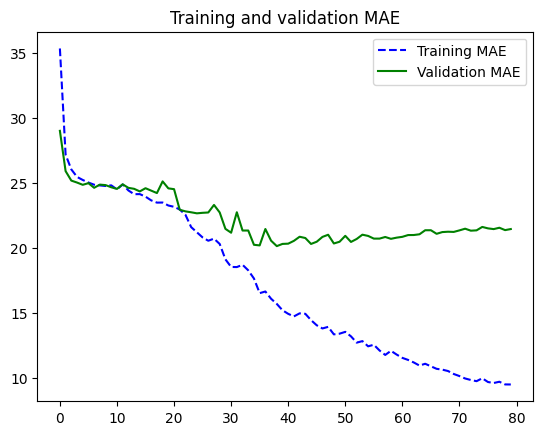

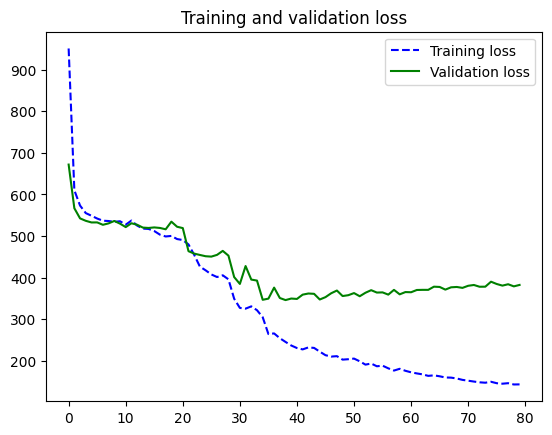

In [42]:
plot_training_analysis(history)